# <font color='red'>Deep Learning Applications: Laboratory #1

<font color='red'>In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
else:
    device = torch.device("cpu")
    x = torch.ones(1, device=device)
print(device)

cuda


### <font color='red'>Exercise 1.1: A baseline MLP</font>

<font color='red'>Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!</font>

<font color='red'>**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.</font>

<font color='red'>**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Training and Testing Pipeline Definition

Per fare il training del modello fino a convergenza, si è deciso di implementare un early-stopping all'interno della training pipeline.

Nota: Queste funzioni vengono utilizzate anche nel resto del notebook

In [3]:
# Funzione per calcolare l'accuracy
def accuracy(y_true, y_pred):
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    
    # Si usa il .flatten() per far funzionare il calcolo dell'accuracy anche nel caso del detector (ultimo esercizio)
    return accuracy_score(y_true.flatten(), y_pred.flatten())

# Funzioni per fare il plot dei risultati della training pipeline
def plot_results(results):
    train_losses, train_accs, test_losses, test_accs = results
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plot_subplot((train_losses, test_losses), ('Train Loss', 'Validation Loss'), 'Epoch', 'Loss', 'Plot of the Loss Function')
    
    plt.subplot(1, 2, 2)
    plot_subplot((train_accs, test_accs), ('Train Accuracy', 'Validation Accuracy'), 'Epoch', 'Accuracy', f'Best Validation Accuracy = {np.max(test_accs):.3f} @ epoch {np.argmax(test_accs)}')
    
    
def plot_subplot(datas, labels, x_label, y_label, title, x=None):
    for i in range(len(datas)):
        if x:
            plt.plot(x, datas[i], label = labels[i])
        else:
            plt.plot(datas[i], label = labels[i])
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [4]:
# Training pipeline
def train(dl_train, model, criterion, optimizer, device, epoch):
    train_loss = list()
    train_accuracy = list()
    model.train()
    for (x_train, y_train) in dl_train:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_accuracy.append(accuracy(y_train, y_pred))
    
    mean_train_loss = np.mean(train_loss)
    mean_train_acc = np.mean(train_accuracy)
    return mean_train_loss, mean_train_acc

# Evaluating pipeline
def evaluate(dl_test, model, criterion, device):
    model.eval()
    test_loss = list()
    test_accuracy = list()
    for (x_test, y_test) in dl_test:

        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        with torch.no_grad():
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
        
        test_loss.append(loss.item())
        test_accuracy.append(accuracy(y_test, y_pred))

    mean_test_loss = np.mean(test_loss)
    mean_test_acc = np.mean(test_accuracy)
    return mean_test_loss, mean_test_acc

In [9]:
# Funzione per il training loop
def run_train(dl_train, dl_val, model, device, n_epochs, lr, early_stopping=False, file=None):
    writer = SummaryWriter()  # tensorboard
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()
    
    # Parametri da usare nel caso in cui sia abilitato l'early-stopping
    best_accuracy = -np.inf
    best_epoch = 0
    no_progress = 0
    patience = 5

    for epoch in range(n_epochs):
        train_loss, train_acc = train(dl_train, model, criterion, optimizer, device, epoch)
        val_loss, val_acc = evaluate(dl_val, model, criterion, device)
        print(
                f"Epoch={epoch} | Train_Loss={train_loss:.3f} | Train_Acc={train_acc:.3f} | Val_Loss={val_loss:.3f} | Val_Acc={val_acc:.3f}"
        )
        
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Acc', train_acc, epoch)
        writer.add_scalar('Val/Loss', val_loss, epoch)
        writer.add_scalar('Val/Acc', val_acc, epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if early_stopping:
            if val_acc > best_accuracy:
                if file:
                    torch.save(model, f'./{file}.pth')
                best_accuracy = val_acc
                best_epoch = epoch
                no_progress = 0
            else:
                no_progress += 1

            if no_progress >= patience:
                break
        
    writer.close()
    if early_stopping:
        print(f'Best epoch: {best_epoch}')
    return train_losses, train_accs, val_losses, val_accs

# Funzione per fare il testing del modello
def run_test(dl_test, model, device):
    writer = SummaryWriter()  # tensorboard
    criterion = nn.CrossEntropyLoss()

    test_loss, test_acc = evaluate(dl_test, model, criterion, device)
    print(
             f"Val_Loss={test_loss:.3f} | Val_Acc={test_acc:.3f}"
    )
    
    writer.close()
    return test_loss, test_acc

#### Dataset Preparation

In [10]:
# MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Carica MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Divide train in train e validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Model Definition

Definizione di un baseline MLP

In [11]:
class myMLP(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(in_size, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
    def forward(self, x):
        x = self.net(x)
        return x

#### Experiment

In [12]:
# Training hyperparameters
input_size = 28*28
batch_size = 128
n_epochs = 100 # posso mettere un numero così alto perché tanto ho messo l'early-stopping
lr = 0.0001

# Early-stopping
early_stopping = True

# DataLoaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

In [13]:
# Definizione del modello
model = myMLP(input_size).to(device)

# Train modello fino a convergenza
MLP_train_results = run_train(dl_train, dl_val, model, device, n_epochs, lr, early_stopping)

Epoch=0 | Train_Loss=1.199 | Train_Acc=0.689 | Val_Loss=0.510 | Val_Acc=0.878
Epoch=1 | Train_Loss=0.414 | Train_Acc=0.890 | Val_Loss=0.329 | Val_Acc=0.914
Epoch=2 | Train_Loss=0.316 | Train_Acc=0.911 | Val_Loss=0.280 | Val_Acc=0.923
Epoch=3 | Train_Loss=0.275 | Train_Acc=0.921 | Val_Loss=0.250 | Val_Acc=0.929
Epoch=4 | Train_Loss=0.249 | Train_Acc=0.928 | Val_Loss=0.232 | Val_Acc=0.934
Epoch=5 | Train_Loss=0.230 | Train_Acc=0.933 | Val_Loss=0.217 | Val_Acc=0.935
Epoch=6 | Train_Loss=0.215 | Train_Acc=0.938 | Val_Loss=0.205 | Val_Acc=0.941
Epoch=7 | Train_Loss=0.201 | Train_Acc=0.943 | Val_Loss=0.197 | Val_Acc=0.944
Epoch=8 | Train_Loss=0.190 | Train_Acc=0.946 | Val_Loss=0.189 | Val_Acc=0.949
Epoch=9 | Train_Loss=0.180 | Train_Acc=0.948 | Val_Loss=0.180 | Val_Acc=0.949
Epoch=10 | Train_Loss=0.171 | Train_Acc=0.951 | Val_Loss=0.174 | Val_Acc=0.951
Epoch=11 | Train_Loss=0.164 | Train_Acc=0.952 | Val_Loss=0.169 | Val_Acc=0.952
Epoch=12 | Train_Loss=0.157 | Train_Acc=0.955 | Val_Loss=0.164

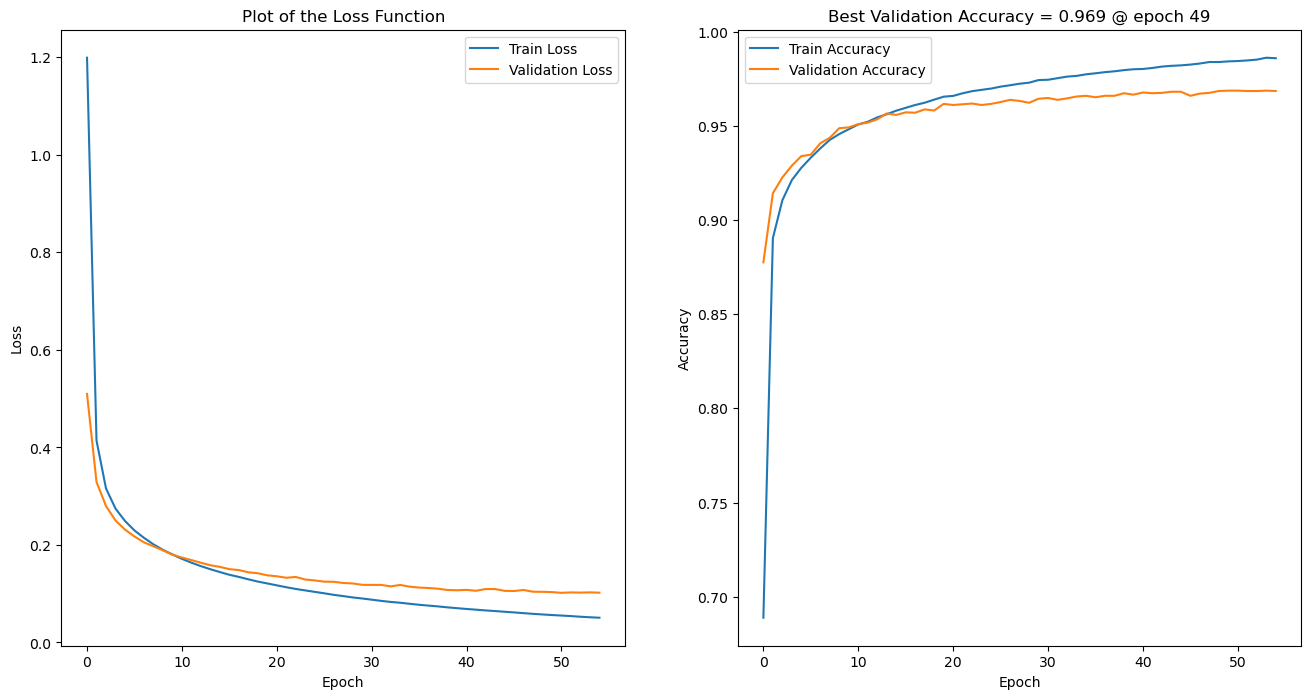

In [14]:
# Plot dei risultati del modello
plot_results(MLP_train_results)

### <font color='red'>Exercise 1.2: Rinse and Repeat

<font color='red'>Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

<font color='red'>**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

<font color='red'>**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### Dataset Preparation

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
# CIFAR10 transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])
# Carica CIFAR10 train e test.
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dividi train in train e validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

Files already downloaded and verified
Files already downloaded and verified


#### Model Definition

Definizione di una CNN. Si è deciso di rendere il modello il più astratto possibile: in questo modo si possono scegliere quanti hidden layers inserire nel modello e anche instanziare una rete con o senza residual connections

In [17]:
class myCNN(nn.Module):
    def __init__(self, n_h_layers, size, is_residual=False, res_step=2):
        super().__init__()
        self.is_residual = is_residual
        self.res_step = res_step
        
        stride = 1
        dilation = 1
        kernel_size = 3
        padding = 1
        pooling = 1
        linear_size = size
        for _ in range(n_h_layers+1):
            linear_size = ((linear_size + 2*padding - dilation*(kernel_size-1)-1)//stride)+1
            linear_size = linear_size//pooling
        
       
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=50, kernel_size=(3,3), padding=1),
            nn.ReLU(),
        )
        
        self.hidden_layers = nn.ModuleList()
        
        for _ in range(n_h_layers):
            self.hidden_layers.append(nn.Sequential(
                nn.Conv2d(in_channels=50, out_channels=50, kernel_size=3, padding=1),
                nn.ReLU(),
            ))
               
        self.output_layer =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(50*linear_size*linear_size, 300),
            nn.ReLU(),
            nn.Linear(300, 10)
        )
            
        
    def forward(self, x):
        x = self.input_layer(x)
        res = x
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            if (i+1)%(self.res_step) == 0 and self.is_residual:
                x = x+res
                res = x
        x = self.output_layer(x)
        return x

#### Experiment

In [18]:
# Training hyperparameters.
n_epochs = 100
lr = 0.001
batch_size = 128

# Early-stopping
early_stopping = True

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

In [19]:
# Model1
model1 = myCNN(1, 32).to(device) #Simple CNN without residual connetions

# Train model1
CNN1_train_results = run_train(dl_train, dl_val, model1, device, n_epochs, lr, early_stopping, 'model1')

Epoch=0 | Train_Loss=1.393 | Train_Acc=0.501 | Val_Loss=1.153 | Val_Acc=0.594
Epoch=1 | Train_Loss=0.967 | Train_Acc=0.656 | Val_Loss=0.997 | Val_Acc=0.643
Epoch=2 | Train_Loss=0.677 | Train_Acc=0.764 | Val_Loss=1.011 | Val_Acc=0.662
Epoch=3 | Train_Loss=0.394 | Train_Acc=0.865 | Val_Loss=1.145 | Val_Acc=0.667
Epoch=4 | Train_Loss=0.165 | Train_Acc=0.949 | Val_Loss=1.483 | Val_Acc=0.653
Epoch=5 | Train_Loss=0.073 | Train_Acc=0.978 | Val_Loss=1.761 | Val_Acc=0.662
Epoch=6 | Train_Loss=0.040 | Train_Acc=0.989 | Val_Loss=1.941 | Val_Acc=0.648
Epoch=7 | Train_Loss=0.043 | Train_Acc=0.987 | Val_Loss=2.170 | Val_Acc=0.637
Epoch=8 | Train_Loss=0.047 | Train_Acc=0.985 | Val_Loss=2.248 | Val_Acc=0.650
Best epoch: 3


In [20]:
# Model2
model2 = myCNN(10, 32).to(device) #Deep CNN without residual connetions

# Train model2
CNN2_train_results = run_train(dl_train, dl_val, model2, device, n_epochs, lr, early_stopping, 'model2')

Epoch=0 | Train_Loss=2.302 | Train_Acc=0.105 | Val_Loss=2.213 | Val_Acc=0.197
Epoch=1 | Train_Loss=1.630 | Train_Acc=0.400 | Val_Loss=1.422 | Val_Acc=0.483
Epoch=2 | Train_Loss=1.252 | Train_Acc=0.547 | Val_Loss=1.193 | Val_Acc=0.569
Epoch=3 | Train_Loss=1.030 | Train_Acc=0.632 | Val_Loss=1.076 | Val_Acc=0.617
Epoch=4 | Train_Loss=0.830 | Train_Acc=0.706 | Val_Loss=1.106 | Val_Acc=0.619
Epoch=5 | Train_Loss=0.644 | Train_Acc=0.770 | Val_Loss=1.160 | Val_Acc=0.629
Epoch=6 | Train_Loss=0.430 | Train_Acc=0.849 | Val_Loss=1.416 | Val_Acc=0.600
Epoch=7 | Train_Loss=0.262 | Train_Acc=0.909 | Val_Loss=1.924 | Val_Acc=0.617
Epoch=8 | Train_Loss=0.150 | Train_Acc=0.948 | Val_Loss=2.199 | Val_Acc=0.614
Epoch=9 | Train_Loss=0.107 | Train_Acc=0.963 | Val_Loss=2.658 | Val_Acc=0.592
Epoch=10 | Train_Loss=0.079 | Train_Acc=0.973 | Val_Loss=2.601 | Val_Acc=0.611
Best epoch: 5


In [22]:
# Model3
model3 = myCNN(15, 32, True).to(device) #Deeper CNN with residual connetions

# Train model3
CNN3_train_results = run_train(dl_train, dl_val, model3, device, n_epochs, lr, early_stopping, 'model3')

Epoch=0 | Train_Loss=1.516 | Train_Acc=0.458 | Val_Loss=1.252 | Val_Acc=0.553
Epoch=1 | Train_Loss=1.091 | Train_Acc=0.611 | Val_Loss=1.045 | Val_Acc=0.630
Epoch=2 | Train_Loss=0.813 | Train_Acc=0.711 | Val_Loss=0.967 | Val_Acc=0.664
Epoch=3 | Train_Loss=0.538 | Train_Acc=0.811 | Val_Loss=1.026 | Val_Acc=0.667
Epoch=4 | Train_Loss=0.247 | Train_Acc=0.916 | Val_Loss=1.341 | Val_Acc=0.651
Epoch=5 | Train_Loss=0.099 | Train_Acc=0.966 | Val_Loss=1.687 | Val_Acc=0.658
Epoch=6 | Train_Loss=0.049 | Train_Acc=0.985 | Val_Loss=1.924 | Val_Acc=0.660
Epoch=7 | Train_Loss=0.048 | Train_Acc=0.984 | Val_Loss=1.905 | Val_Acc=0.650
Epoch=8 | Train_Loss=0.048 | Train_Acc=0.984 | Val_Loss=2.117 | Val_Acc=0.633
Best epoch: 3


Già da questo piccolo esperimento, si può notare che le CNN con residual connections sono migliori di quelle senza residual connections.
In particolare, si osserva che durante il training, la rete con residual connections arriva ad avere il valore più elevato nella sua validation accuracy.
Per osservare se quel valore corrisponde effettivamente anche ad un'accuracy migliore sul test set, si sono caricate le tre reti e si è poi confrontata l'accuracy ottenuta:

In [23]:
# Test models

best1 = torch.load('./model1.pth')
best2 = torch.load('./model2.pth')
best3 = torch.load('./model3.pth')

print("1 hidden layers - no res")
_ = run_test(dl_test, best1, device)
print("10 hidden layers - no res")
_ = run_test(dl_test, best2, device)
print("15 hidden layers - res")
_ = run_test(dl_test, best3, device)

1 hidden layers - no res
Val_Loss=1.149 | Val_Acc=0.656
10 hidden layers - no res
Val_Loss=1.194 | Val_Acc=0.624
15 hidden layers - res
Val_Loss=1.032 | Val_Acc=0.665



----

Per fare uno studio più accurato, si è deciso di addestrare più reti CNN (con e senza residual connections) e di mettere le loro validation accuracies durante il training a confronto attraverso un grafico:

In [24]:
# Train CNNs no res

model_no_res = list()
train_result_no_res = list()
j = 0

for i in range(1, 27, 5):
    print(f'Hidden layers: {i}')
    model_no_res.append(myCNN(i, 32).to(device))
    train_result_no_res.append(run_train(dl_train, dl_val, model_no_res[j], device, n_epochs, lr, early_stopping))
    j = j+1
    print()

Hidden layers: 1
Epoch=0 | Train_Loss=1.370 | Train_Acc=0.508 | Val_Loss=1.126 | Val_Acc=0.607
Epoch=1 | Train_Loss=0.932 | Train_Acc=0.672 | Val_Loss=1.008 | Val_Acc=0.654
Epoch=2 | Train_Loss=0.667 | Train_Acc=0.766 | Val_Loss=0.964 | Val_Acc=0.671
Epoch=3 | Train_Loss=0.403 | Train_Acc=0.862 | Val_Loss=1.106 | Val_Acc=0.674
Epoch=4 | Train_Loss=0.186 | Train_Acc=0.941 | Val_Loss=1.332 | Val_Acc=0.682
Epoch=5 | Train_Loss=0.081 | Train_Acc=0.976 | Val_Loss=1.635 | Val_Acc=0.668
Epoch=6 | Train_Loss=0.044 | Train_Acc=0.988 | Val_Loss=1.815 | Val_Acc=0.676
Epoch=7 | Train_Loss=0.041 | Train_Acc=0.987 | Val_Loss=2.065 | Val_Acc=0.668
Epoch=8 | Train_Loss=0.036 | Train_Acc=0.989 | Val_Loss=2.179 | Val_Acc=0.661
Epoch=9 | Train_Loss=0.036 | Train_Acc=0.988 | Val_Loss=2.287 | Val_Acc=0.661
Best epoch: 4

Hidden layers: 6
Epoch=0 | Train_Loss=1.640 | Train_Acc=0.397 | Val_Loss=1.262 | Val_Acc=0.547
Epoch=1 | Train_Loss=1.112 | Train_Acc=0.603 | Val_Loss=1.106 | Val_Acc=0.613
Epoch=2 | Train

In [25]:
# Train CNNs res

model_res = list()
train_result_res = list()
j = 0

for i in range(6, 32, 5):
    print(f'Hidden layers: {i}')
    model_res.append(myCNN(i, 32, True).to(device))
    train_result_res.append(run_train(dl_train, dl_val, model_res[j], device, n_epochs, lr, early_stopping))
    j=j+1
    print()

Hidden layers: 6
Epoch=0 | Train_Loss=1.599 | Train_Acc=0.458 | Val_Loss=1.299 | Val_Acc=0.542
Epoch=1 | Train_Loss=1.161 | Train_Acc=0.589 | Val_Loss=1.191 | Val_Acc=0.583
Epoch=2 | Train_Loss=1.007 | Train_Acc=0.645 | Val_Loss=1.116 | Val_Acc=0.614
Epoch=3 | Train_Loss=0.873 | Train_Acc=0.693 | Val_Loss=1.124 | Val_Acc=0.613
Epoch=4 | Train_Loss=0.753 | Train_Acc=0.737 | Val_Loss=1.134 | Val_Acc=0.621
Epoch=5 | Train_Loss=0.640 | Train_Acc=0.777 | Val_Loss=1.149 | Val_Acc=0.623
Epoch=6 | Train_Loss=0.529 | Train_Acc=0.818 | Val_Loss=1.183 | Val_Acc=0.633
Epoch=7 | Train_Loss=0.431 | Train_Acc=0.854 | Val_Loss=1.238 | Val_Acc=0.627
Epoch=8 | Train_Loss=0.344 | Train_Acc=0.886 | Val_Loss=1.346 | Val_Acc=0.619
Epoch=9 | Train_Loss=0.262 | Train_Acc=0.916 | Val_Loss=1.462 | Val_Acc=0.627
Epoch=10 | Train_Loss=0.200 | Train_Acc=0.938 | Val_Loss=1.565 | Val_Acc=0.627
Epoch=11 | Train_Loss=0.147 | Train_Acc=0.957 | Val_Loss=1.743 | Val_Acc=0.623
Best epoch: 6

Hidden layers: 11
Epoch=0 | Tr

In [26]:
# Plot dei risultati
data = list()
name = list()
max_acc_no_res = list()
max_acc_res = list()
i = 1
for _, _, _, val_acc in train_result_no_res:
    data.append(val_acc)
    if i != 1:
        max_acc_no_res.append(max(val_acc))
    name.append(f'no res - {i} hl')
    i = i+5

i = 6
for _, _, _, val_acc in train_result_res:
    data.append(val_acc)
    if i != 31:
        max_acc_res.append(max(val_acc))
    name.append(f'res - {i} hl')
    i = i+5

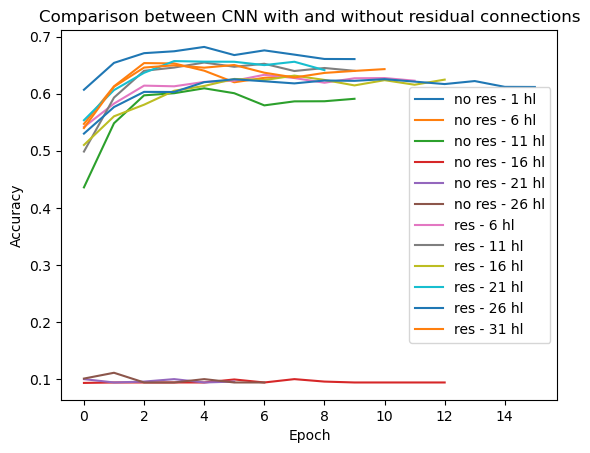

In [27]:
plot_subplot(
    data,
    name,
    'Epoch',
    'Accuracy',
    'Comparison between CNN with and without residual connections')

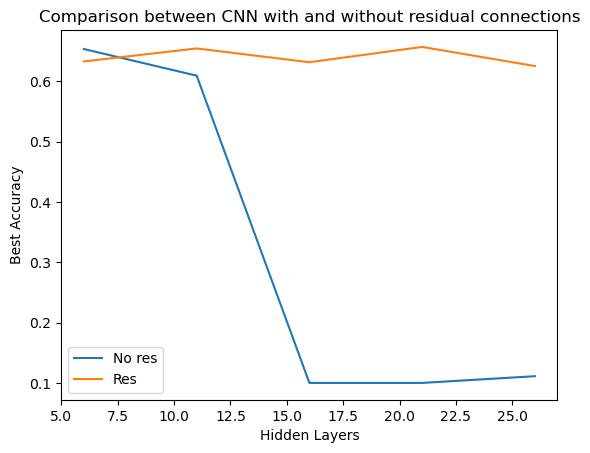

In [28]:
plot_subplot(
    (max_acc_no_res, max_acc_res),
    ('No res', 'Res'),
    'Hidden Layers',
    'Best Accuracy',
    'Comparison between CNN with and without residual connections',
    [i for i in range(6, 27, 5)])

Il risultato conferma la nostra tesi.

Infine, si è deciso di fare uno studio anche sul numero di residual connections all'interno della rete. Nello scorso esperimento, la rete aveva una residual connection un layer sì e uno no. Adesso invece proviamo a ripetere l'esperimento usando una rete con una residual connection ogni 2 layer senza residual connections.

In [29]:
# Train CNNs res (2)

model_res_2 = list()
train_result_res_2 = list()
j = 0

for i in range(6, 27, 5):
    print(f'Hidden layers: {i}')
    model_res_2.append(myCNN(i, 32, True, 3).to(device))
    train_result_res_2.append(run_train(dl_train, dl_val, model_res_2[j], device, n_epochs, lr, early_stopping))
    j=j+1
    print()

Hidden layers: 6
Epoch=0 | Train_Loss=1.579 | Train_Acc=0.462 | Val_Loss=1.314 | Val_Acc=0.523
Epoch=1 | Train_Loss=1.151 | Train_Acc=0.592 | Val_Loss=1.198 | Val_Acc=0.576
Epoch=2 | Train_Loss=0.988 | Train_Acc=0.653 | Val_Loss=1.117 | Val_Acc=0.612
Epoch=3 | Train_Loss=0.846 | Train_Acc=0.704 | Val_Loss=1.110 | Val_Acc=0.623
Epoch=4 | Train_Loss=0.710 | Train_Acc=0.752 | Val_Loss=1.155 | Val_Acc=0.624
Epoch=5 | Train_Loss=0.586 | Train_Acc=0.798 | Val_Loss=1.153 | Val_Acc=0.631
Epoch=6 | Train_Loss=0.463 | Train_Acc=0.842 | Val_Loss=1.256 | Val_Acc=0.628
Epoch=7 | Train_Loss=0.364 | Train_Acc=0.879 | Val_Loss=1.322 | Val_Acc=0.635
Epoch=8 | Train_Loss=0.262 | Train_Acc=0.916 | Val_Loss=1.446 | Val_Acc=0.628
Epoch=9 | Train_Loss=0.195 | Train_Acc=0.940 | Val_Loss=1.589 | Val_Acc=0.626
Epoch=10 | Train_Loss=0.141 | Train_Acc=0.959 | Val_Loss=1.697 | Val_Acc=0.627
Epoch=11 | Train_Loss=0.103 | Train_Acc=0.972 | Val_Loss=1.942 | Val_Acc=0.626
Epoch=12 | Train_Loss=0.087 | Train_Acc=0.976

In [30]:
# Plot dei risultati

max_acc_res_2 = list()

i = 6
for _, _, _, val_acc in train_result_res_2:
    data.append(val_acc)
    max_acc_res_2.append(max(val_acc))
    name.append(f'res2 - {i} hl')
    i = i+5

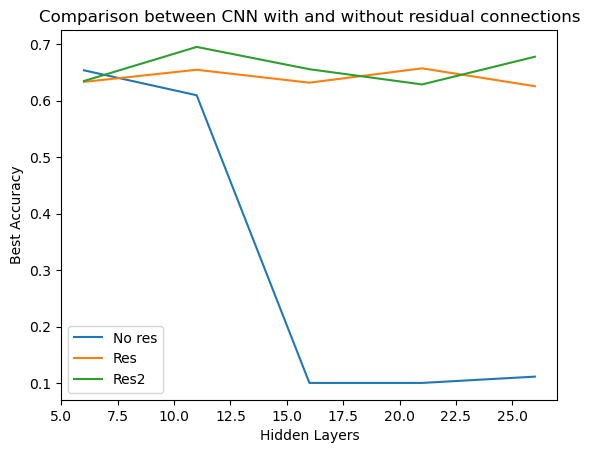

In [32]:
plot_subplot(
    (max_acc_no_res, max_acc_res, max_acc_res_2),
    ('No res', 'Res', 'Res2'),
    'Hidden Layers',
    'Best Accuracy',
    'Comparison between CNN with and without residual connections',
    [i for i in range(6, 27, 5)])

Come si può vedere dal grafico, i due tipi di ResNet sono abbastanza simili. Di conseguenza, non c'è una vera e propria differenza causata dal numero di residual connections all'interno della rete.

### <font color='red'>Exercise 2.2: Fully-convolutionalize a network.
<font color='red'>Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

<font color='red'>**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

<font color='red'>**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

Nota: le classi TargetTransform e DatasetWrapper usate per generare il dataset per testare il detector si trovano nel file target_transform.py

In [46]:
from target_transform import TargetTransform, DatasetWrapper

# MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform, target_transform=TargetTransform(28,28))
ds_test = MNIST(root='./data', train=False, download=True, transform=transform, target_transform=TargetTransform(28,28))

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [47]:
class myCNN_FC(nn.Module):
    def __init__(self, n_h_layers, is_residual=False):
        super().__init__()
        self.is_residual = is_residual
       
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.hidden_layers = nn.ModuleList()
        
        for _ in range(n_h_layers):
            self.hidden_layers.append(nn.Sequential(
                nn.Conv2d(in_channels=50, out_channels=50, kernel_size=3, padding=1),
                nn.ReLU(),
            ))
               
        self.output_layer =  nn.Sequential(
            nn.Conv2d(in_channels=50, out_channels=10, kernel_size=1)
        )
            
        
    def forward(self, x):
        x = self.input_layer(x)
        res = x
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            if i%2 and self.is_residual:
                x = x+res
                res = x
        x = self.output_layer(x)
        return x

In [48]:
# Training hyperparameters.
n_epochs = 50
lr = 0.001
batch_size = 128

# Early-stopping
early_stopping = True

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)

In [58]:
# Model
model = myCNN_FC(2).to(device)

# Train model
CNN_FC_train_results = run_train(dl_train, dl_val, model, device, n_epochs, lr, early_stopping, 'fully-connected')

Epoch=0 | Train_Loss=2.208 | Train_Acc=0.172 | Val_Loss=2.150 | Val_Acc=0.203
Epoch=1 | Train_Loss=2.114 | Train_Acc=0.213 | Val_Loss=2.096 | Val_Acc=0.226
Epoch=2 | Train_Loss=2.080 | Train_Acc=0.227 | Val_Loss=2.067 | Val_Acc=0.238
Epoch=3 | Train_Loss=2.060 | Train_Acc=0.235 | Val_Loss=2.055 | Val_Acc=0.241
Epoch=4 | Train_Loss=2.048 | Train_Acc=0.239 | Val_Loss=2.041 | Val_Acc=0.246
Epoch=5 | Train_Loss=2.038 | Train_Acc=0.243 | Val_Loss=2.039 | Val_Acc=0.246
Epoch=6 | Train_Loss=2.031 | Train_Acc=0.246 | Val_Loss=2.022 | Val_Acc=0.254
Epoch=7 | Train_Loss=2.025 | Train_Acc=0.248 | Val_Loss=2.021 | Val_Acc=0.252
Epoch=8 | Train_Loss=2.019 | Train_Acc=0.251 | Val_Loss=2.017 | Val_Acc=0.254
Epoch=9 | Train_Loss=2.016 | Train_Acc=0.252 | Val_Loss=2.022 | Val_Acc=0.250
Epoch=10 | Train_Loss=2.012 | Train_Acc=0.253 | Val_Loss=2.009 | Val_Acc=0.258
Epoch=11 | Train_Loss=2.008 | Train_Acc=0.255 | Val_Loss=2.010 | Val_Acc=0.256
Epoch=12 | Train_Loss=2.005 | Train_Acc=0.256 | Val_Loss=2.003

Per testare il modello come un detector si creano due diversi datasets. La classe DatasetWrappers crea delle immagini a "griglia" dove ogni elemento della griglia è un'immagine causale di MNIST.

In [59]:
# Test Datasets & DataLoaders
ds_test1 = DatasetWrapper(ds_test, size=1000, n_rows=2, n_cols=3)
ds_test2 = DatasetWrapper(ds_test, size=2000, n_rows=4, n_cols=1)

dl_test = torch.utils.data.DataLoader(ds_test, batch_size, num_workers=4)
dl_test1 = torch.utils.data.DataLoader(ds_test1, batch_size, num_workers=4)
dl_test2 = torch.utils.data.DataLoader(ds_test2, batch_size, num_workers=4)

In [60]:
# Test model as a detector
run_test(dl_test1, model, device)
run_test(dl_test2, model, device)

Val_Loss=2.005 | Val_Acc=0.261
Val_Loss=2.016 | Val_Acc=0.257


(2.0164427906274796, 0.2570749088209503)

Si vede che il modello si comporta da detector perché, anche se le accuracy sono molto basse, coicindono con quelle ottenute durante il training. Quindi il modello si comporta in maniera analoga sia se ha in input un'immagine con solo una cifra, sia se ha in input immagini con più cifre.